## Data setup and Transforms


In [145]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

img_size = 180 # choose the following image and batch size ,dont want to make the baseline too accuracte/
batch_size = 64 

##Transforms

#Asked Ai for methods on how to apply gausisan noise into image in tensor / pytorch
class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0.0, std=8.0, factor=1.0):
        super().__init__()
        self.mean = mean
        self.std = std * factor 
        
    def forward(self, img):
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input nedds to be tensor")
        noise = torch.randn_like(img) * self.std / 255.0 
        return torch.clamp(img + noise, 0.0, 1.0) 

data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),# scaled back down to 10 degrees
    transforms.RandomResizedCrop(180, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #- testing with color jitter on/off
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), #just limit to small shift no rotation in this part coverdc in the rand rotation portion
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # base needs to use for image net , has to apply to all transformas
])

noise_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=8),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#used manually split datast instead of using pytorch methods, makes it convenient for applying transforms for training set only
train_dir = 'C:/Users/jerom/cmpt419/DiseaseFinal/train'
test_dir = 'C:/Users/jerom/cmpt419/DiseaseFinal/test'
val_dir = 'C:/Users/jerom/cmpt419/DiseaseFinal/val'

original_train_dataset = datasets.ImageFolder(train_dir, transform=base_transform) # will serve as data for baseline, also used for adding with augmented set etc.

#can load , no transformations
val_dataset = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)






Using device: cuda


## Modifications and declaration for Train Loader

In [ ]:

reduction_factor = 0.6  
reduced_train_size = int(reduction_factor * len(original_train_dataset))
reduced_train_subset, _ = random_split(original_train_dataset, [reduced_train_size, len(original_train_dataset) - reduced_train_size])

#Dataset for only augmented
augmented_train_dataset = datasets.ImageFolder(train_dir, transform=data_augmentation_transforms)

#reduction + augmentation
reduced_aug_train_subset, _ = random_split(augmented_train_dataset, [reduced_train_size, len(augmented_train_dataset) - reduced_train_size])

#Dataset tasting for noise apply to all images.
augmented_train_dataset_with_noise = datasets.ImageFolder(train_dir, transform=noise_transform)

augmented_train_size = int(0.3 * len(augmented_train_dataset))  # Take only 70% of augmented data
augmented_train_subset, _ = random_split(augmented_train_dataset, [augmented_train_size, len(augmented_train_dataset) - augmented_train_size])

# **Combine Original, Augmented (70%), and Noisy Datasets**
combined_train_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset])
#combined_train_dataset = ConcatDataset([reduced_train_subset, augmented_train_subset])

#for testing with 50% noisy 50% normal 

reduced_noisy_subset, _ = random_split(augmented_train_dataset_with_noise, [reduced_train_size, len(original_train_dataset) - reduced_train_size])
combined_train_noisy_dataset = ConcatDataset([reduced_train_subset, reduced_noisy_subset])

#substitute datasets for the model here 
train_loader = DataLoader(original_train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_loader.dataset)}")# verify if right amount of images 
#print(f"Validation set size: {len(val_loader.dataset)}")
#print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 3438
Validation set size: 729
Test set size: 729


## Running ResNet50

In [ ]:

model = models.resnet50(pretrained=True)

# freezelayers of the pretrained resnet50 model except final 
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 9) # set the last layer to 9 to match my classes


# referred to prior knowledge in ENSC 429 to build training loop and val loops
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# training loop
epochs = 12
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    #training statistics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    # validation
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")
    
torch.save(model.state_dict(), 'reduced_40.pt')
print('Saved as reduced_40.pt')

Epoch 1/12, Loss: 1.9901, Accuracy: 0.2989
Validation Accuracy: 0.3951
Epoch 2/12, Loss: 1.4545, Accuracy: 0.5375
Validation Accuracy: 0.5679
Epoch 3/12, Loss: 1.1843, Accuracy: 0.6764
Validation Accuracy: 0.6310
Epoch 4/12, Loss: 1.0311, Accuracy: 0.7280
Validation Accuracy: 0.6790
Epoch 5/12, Loss: 0.9303, Accuracy: 0.7687
Validation Accuracy: 0.7284
Epoch 6/12, Loss: 0.8356, Accuracy: 0.7847
Validation Accuracy: 0.7106
Epoch 7/12, Loss: 0.7995, Accuracy: 0.7920
Validation Accuracy: 0.7215
Epoch 8/12, Loss: 0.7490, Accuracy: 0.7935
Validation Accuracy: 0.6626
Epoch 9/12, Loss: 0.6980, Accuracy: 0.8131
Validation Accuracy: 0.7503
Epoch 10/12, Loss: 0.6479, Accuracy: 0.8371
Validation Accuracy: 0.7490
Epoch 11/12, Loss: 0.6155, Accuracy: 0.8451
Validation Accuracy: 0.7695
Epoch 12/12, Loss: 0.5809, Accuracy: 0.8545
Validation Accuracy: 0.7545
Model saved as reduced_40.pt


## Testing Loops and Confusion Matrix

c:\Users\jerom\anaconda3\envs\429\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jerom\anaconda3\envs\429\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jerom\AppData\Local\Temp\ipykernel_55604\381384213.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorc

Test Accuracy: 83.68%


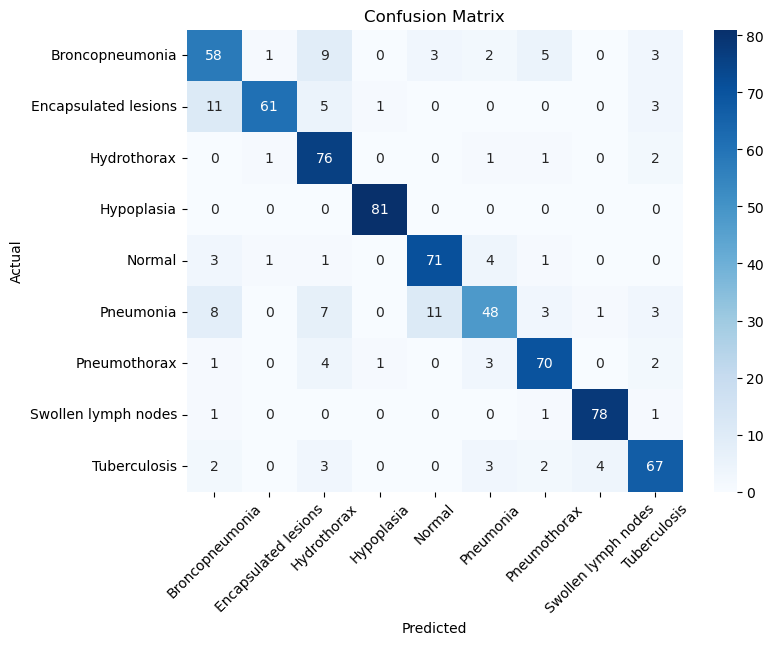

In [141]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_path):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 9)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

#load the model we want- swtich it oout with one we want to test
model_path = 'realBaseline.pt'
model = load_model(model_path)

#store for confusion matrix
all_preds = []
all_labels = []

#for accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # asked chat how to extend confusion matrix into pyTorch etc in this particulatr manner
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Test accuracy metric 1 
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

#confusion matrix metric 2
cm = confusion_matrix(all_labels, all_preds)


dataset = datasets.ImageFolder(root="Disease/")
class_names = dataset.classes
#Cm plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45) 
plt.show()


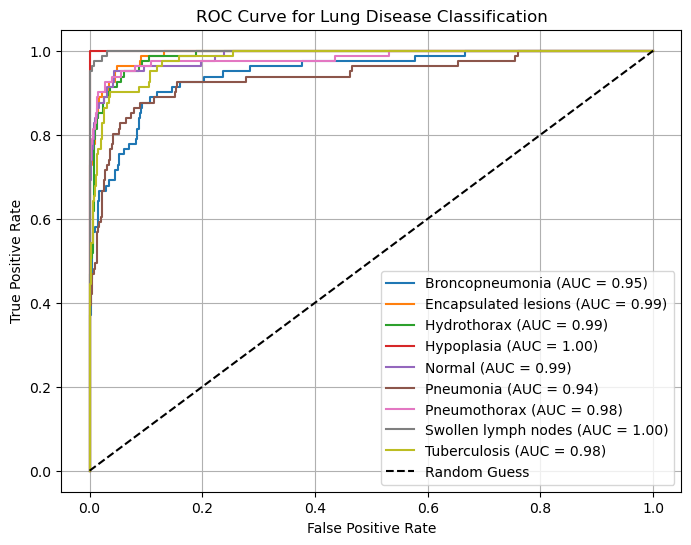

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

all_preds = []  
all_labels = [] 

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #used chat and asked how to do this in pytorch
        probs = torch.softmax(outputs, dim=1)   
        
        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# refered to Assignment 2 ROC curve implemntation
# also asked chat how to apply to multi classes
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
n_classes = len(class_names)
y_true = label_binarize(all_labels, classes=np.arange(n_classes))

# plot curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# 50/50 line 
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Lung Disease Classification")
plt.legend()
plt.grid()
plt.show()


In [112]:
count = 0 
dirs = os.listdir('C:/Users/jerom/cmpt419/DiseaseFinal/val/')
for dir in dirs:
    files = list(os.listdir('C:/Users/jerom/cmpt419/DiseaseFinal/val/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Disease Folder has '+ str(count) + ' Diseases')

Broncopneumonia Folder has 81 Images
Encapsulated lesions Folder has 81 Images
Hydrothorax Folder has 81 Images
Hypoplasia Folder has 81 Images
Normal Folder has 81 Images
Pneumonia Folder has 81 Images
Pneumothorax Folder has 81 Images
Swollen lymph nodes Folder has 81 Images
Tuberculosis Folder has 81 Images
Disease Folder has 729 Diseases
